# Importaçoes

In [1]:
import numpy as np 
import pandas as pd 


import os
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Input, Dropout, add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from PIL import Image
from tqdm import tqdm
import pickle
import re


2024-12-04 21:13:26.360589: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 21:13:26.677834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 21:13:26.677898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 21:13:26.731864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 21:13:26.839805: I tensorflow/core/platform/cpu_feature_guar

# Abrindo os dados

In [4]:
#Images folder path
IMAGES_PATH = "Images"
#Caption CSV file path
CAPTIONS_PATH = "captions.txt"

In [5]:
df = pd.read_csv(CAPTIONS_PATH, on_bad_lines='skip', sep = ",")
df = df.dropna()
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## Filtrando as legendas

Nessa seçao filtraremos as legendas, tornando elas minusculas, removendo palavras de tamanho igual a um, pois elas pioram as legendas geradas, alem de adicionar duas palavras especiais de começo e final de sequencia.

Também faremos um dicionario onde as chaves serão os nomes dos arquivos e os valores serão as legendas de cada arquivo(um vetor de strings).

In [6]:
def clean(captions):
    # Convert to lowercase
    captions = captions.lower()
    # Remove numbers, special characters, e o caractere '
    captions = re.sub(r"[^a-z\s]", "", captions)
    # Replace multiple spaces with a single space
    captions = re.sub(r'\s+', ' ', captions).strip()
    # Add start and end sequence tokens
    captions = 'startseq ' + " ".join([word for word in captions.split() if len(word) > 1]) + ' endseq'
    return captions


In [7]:
df["caption"] = df["caption"].apply(clean)
for cap in df["caption"].values[:5]:
    print(cap)

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [8]:
dict_img_to_captions = {}
for i in range(len(df)):
    row = df.iloc[i]
    img = row["image"]
    cap = row["caption"]
    if dict_img_to_captions.get(img) is None:
        dict_img_to_captions[img] = []
    dict_img_to_captions[img].append(cap)

## Tokenizando

Nessa seçao ajustaremos o tokenizer, que será mais util na hora de gerar as entradas para o modelo

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["caption"].values)

In [10]:
for i in df["caption"].values[:2]:
    print(i)
    print(tokenizer.texts_to_sequences([i])[0])
    print()

startseq child in pink dress is climbing up set of stairs in an entry way endseq
[1, 41, 3, 89, 168, 6, 118, 52, 393, 11, 390, 3, 27, 5192, 691, 2]

startseq girl going into wooden building endseq
[1, 18, 312, 63, 192, 116, 2]



# Extraindo features das imagens

Aqui usaremos uma rede pré treinada, chamada de VGG16 para extrair as features de todas as imagens do nosso conjunto de dados.

Também criaremos um novo dicionario, de imagem para vetor de caracteristicas e o salvaremos para evitar computações desnecessarias em execuções posteriores.

Extrair as features de antemão ajuda a economizar muita memoria e tempo na hora de treinar o modelo.

In [85]:
from tensorflow.keras.applications import VGG16

def create_vgg_feature_extractor():
    base_model = VGG16()
    return Model(inputs = base_model.inputs , outputs = base_model.layers[-3].output, name="VGG_FeatureExtractor")

vgg_feature_extractor = create_vgg_feature_extractor()
print(vgg_feature_extractor.summary())

Model: "VGG_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

In [86]:
dummy_input = np.random.randn(1, 224, 224, 3)
dummy_output = vgg_feature_extractor.predict(dummy_input)
dummy_output.shape

1/1 [==============================] - 0s 250ms/step


(1, 4096)

In [87]:
def transform_image(image):
    # Redimensiona a imagem para 224x224
    image = image.resize((224, 224))
    # Converte a imagem para um array numpy
    image_array = np.array(image)
    # Adiciona uma dimensão para representar o lote
    image_array = np.expand_dims(image_array, axis=0)
    # Pré-processa a imagem para o modelo ResNet50
    image_array = tf.keras.applications.resnet50.preprocess_input(image_array)
    return image_array

### Salvando o vetor das imagens

In [88]:
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def process_image(img):
#     img_path = os.path.join(IMAGES_PATH, img)
#     image = Image.open(img_path)
#     image = transform_image(image)
#     features = vgg_feature_extractor.predict(image, verbose=0)
#     return img, features

# vetor_imagens = {}
# with ThreadPoolExecutor() as executor:
#     future_to_image = {executor.submit(process_image, img): img for img in os.listdir(IMAGES_PATH)}
#     for future in tqdm(as_completed(future_to_image), total=len(future_to_image)):
#         img, features = future.result()
#         vetor_imagens[img] = features

In [89]:
pickle_file_path = 'modelv1/vetor_imagens.pkl'

# with open(pickle_file_path, 'wb') as f:
#     pickle.dump(vetor_imagens, f)

# print(f'Dicionário salvo como pickle em {pickle_file_path}')

In [90]:
# load features from pickle
with open(pickle_file_path, 'rb') as f:
    vetor_imagens = pickle.load(f)
    print(f'Dicionário carregado de {pickle_file_path}')

Dicionário carregado de modelv1/vetor_imagens.pkl


# Load no embbeding pre treinado word2vec skipgram

In [94]:
def load_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


In [95]:
def create_embedding_matrix(embeddings, tokenizer, embedding_dim):
    vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
    print(f'Vocabulary size: {vocab_size}')
    embedding_matrix = np.random.randn(vocab_size, embedding_dim)
    cont =0
    for word, index in tokenizer.word_index.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
            cont +=1
    print(f'Embeddings encontrados para {cont} palavras')
    return embedding_matrix


In [96]:
embeds = load_embeddings('vectors_skipgram_w4_s128_i5.txt')
embeds['startseq'] = embeds['</s>']
embedding_matrix = create_embedding_matrix(embeds, tokenizer, 128)
embedding_matrix.shape

Vocabulary size: 8768
Embeddings encontrados para 6524 palavras


(8768, 128)

# Modelo LSTM

Aqui definimos nosso modelo, que recebera duas entradas, a primeira sendo o vetor de features da imagem, e sua legenda.

In [15]:
embedding_dim = 256
intern_layer = 256
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(i.split()) for i in df["caption"].values])

In [98]:
caption_network = keras.Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix]),
    LSTM(512),
    Dropout(0.35),
    Dense(intern_layer, activation='relu'),
    ]
)

image_network = keras.Sequential([
    Input(shape=(4096,)),
    Dense(intern_layer, activation='relu'),
    # Dropout(0.1),
    ]
)

#combined_network = add([caption_network.output, image_network.output])
combined_network = Concatenate()([caption_network.output, image_network.output])
#dropout = Dropout(0.35)(combined_network)
combined_network = Dense(256, activation='relu')(combined_network)
output = Dense(vocab_size, activation='softmax')(combined_network)

In [ ]:
# caption_network = keras.Sequential([
#     Input(shape=(max_length,)),
#     Embedding(vocab_size, embedding_dim, mask_zero=True),
#     Dropout(0.35),
#     LSTM(256, return_sequences=True),
#     LSTM(256),
#     Dense(intern_layer, activation='relu'),
#     ]
# )

# image_network = keras.Sequential([
#     Input(shape=(2048,)),
#     #Dense(intern_layer, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),
#     Dense(256, activation='relu'),
#     ]
# )

# #combined_network = add([caption_network.output, image_network.output])
# combined_network = add([caption_network.output, image_network.output])
# dropout = Dropout(0.35)(combined_network)
# combined_network = Dense(256, activation='relu')(combined_network)
# output = Dense(vocab_size, activation='softmax')(combined_network)

In [17]:
model = Model(inputs=[image_network.input, caption_network.input ], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

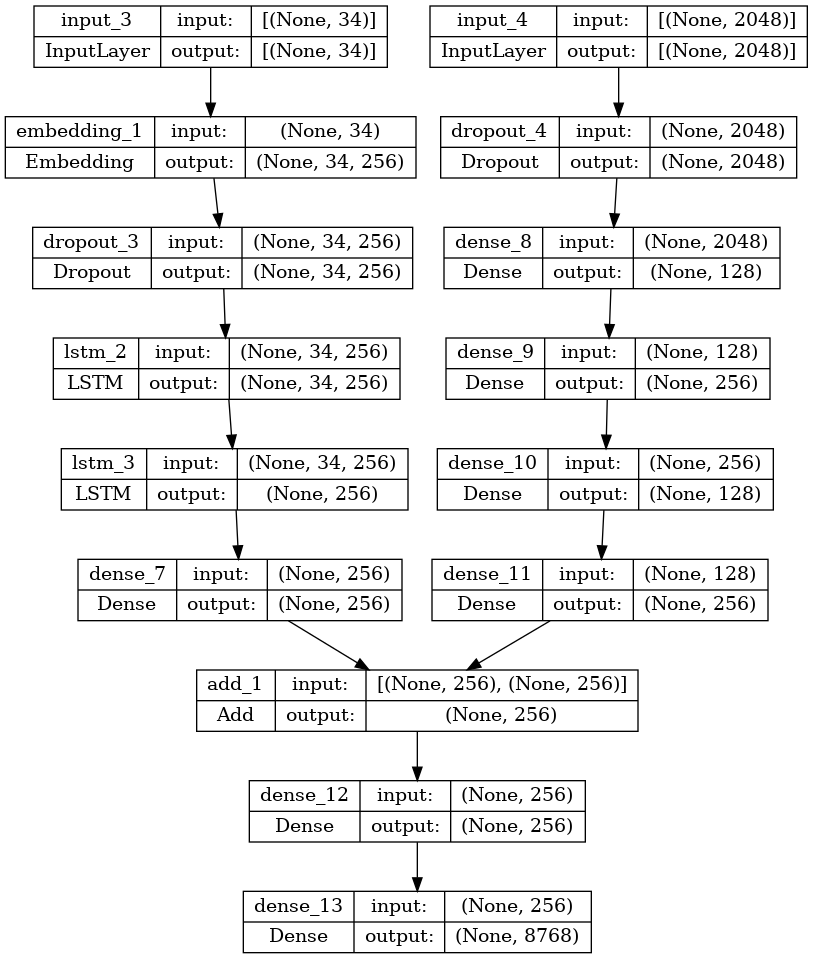

In [18]:
plot_model(model, show_shapes=True)

Vale ressaltar o uso de dropouts para evitar o overfit da rede e da loss "categorical_crossentropy"

# Criando gerador dos dados

Gerador de dados que prepara batches para o treinamento de um modelo de legendas de imagem.
Ele utiliza as características das imagens (vetor_imagens) e as legendas associadas (img_to_cap).
Para cada imagem e legenda:
- Divide as legendas em sequências de entrada (in_seq) e saídas esperadas (out_seq).
- Padroniza o tamanho das sequências e converte as saídas para one-hot encoding.
- Organiza os dados em batches do tamanho especificado (batch_size) e os retorna.
O gerador é usado em treinamento incremental com grandes volumes de dados.


In [101]:
print(len(vetor_imagens))
print(len(dict_img_to_captions))

8091
8091


In [103]:
print(max_length)
print(vocab_size)

34
8768


In [104]:
def data_generator(img_to_cap, vetor_imagens,batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i in img_to_cap.keys():
            n += 1
            img = vetor_imagens[i][0]
            for cap in img_to_cap[i]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [105]:
#Testa o gerador de dados
gerador = data_generator(dict_img_to_captions, vetor_imagens, 32)
X, y = next(gerador)
print(X[0].shape)
print(X[1].shape)
print(y.shape)

(1746, 4096)
(1746, 34)
(1746, 8768)


# Treinamento do modelo

## Treino e teste split

In [106]:
import random

chaves_imagens = list(dict_img_to_captions.keys())

random.shuffle(chaves_imagens)

n_treino = int(len(chaves_imagens) * 0.8)
chaves_treino = chaves_imagens[:n_treino]
chaves_teste = chaves_imagens[n_treino:]

# Resultados
print(f"Treino: {len(chaves_treino)} imagens")
print(f"Teste: {len(chaves_teste)} imagens")


Treino: 6472 imagens
Teste: 1619 imagens


In [107]:
train_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_treino}
test_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_teste}

## Treinamento 

In [108]:
epocas = 20
batche_size = 32
steps = len(train_dict_img_to_captions)//batche_size

for i in range(epocas):
    generator = data_generator({k: dict_img_to_captions[k] for k in chaves_treino}, vetor_imagens, 32)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    if i%5 == 0:
        model.save(f'model/modelo_{i}.h5')

202/202 [==============================] - 588s 3s/step - loss: 5.0199


/home/bdlemos/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


202/202 [==============================] - 580s 3s/step - loss: 1.9788


In [ ]:
model.save(f'model/modelo_{20}.h5')
# model.load_weights('model/modelo_20.h5')

# Gerando legendas

In [110]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [118]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        # yhat = yhat.squeeze()
        # yhat = np.random.choice(len(yhat), p=yhat)
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

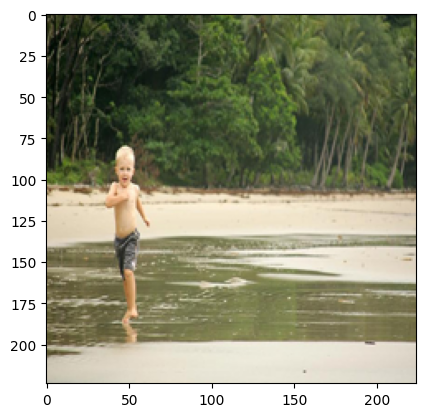

Caption: boy in red shorts and shorts jumping into the water
Real: small child running on the beach
Real: young boy in swim trunks runs along sandy beach
Real: young boy runs through the water on beach near trees
Real: young child is running through large puddle at beach surrounded by trees
Real: young boy walking along the beach



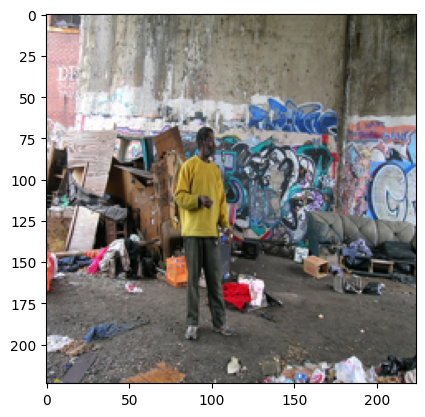

Caption: man and woman are standing in front of family drawing with statue
Real: man in yellow stands in garbage strewn underpass
Real: man stands near garbage and spray painted drawing
Real: man wearing yellow shirt is standing in front of cement wall with drawings on it
Real: man wearing yellow shirt standing in the middle of bunch of garbage and graffitied wall
Real: man wearing yellow shirt standing near some refuse



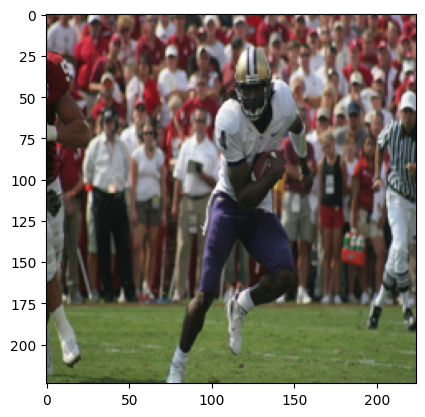

Caption: football player tackles player from the field
Real: football player clutches the ball while running down the field
Real: football player running with the ball
Real: football player running with the ball at game
Real: football player wearing gold helmet runs holding football
Real: an american footballer in white strip is making run with the ball



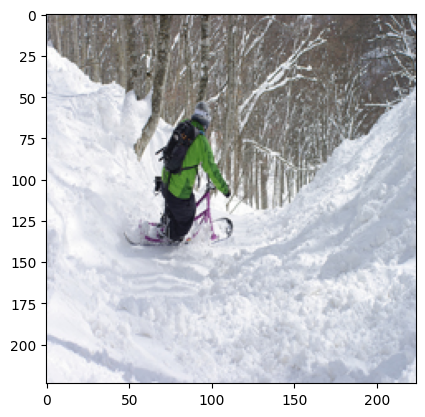

Caption: the mountain climber is descending down snowy hill
Real: man going down the hill in the snow
Real: person bicycling through deep snow
Real: skier in bright green jacket sliding downhill
Real: person in green jacket and backpack biking through snow
Real: the man wearing green jacket is riding bike through deep snow



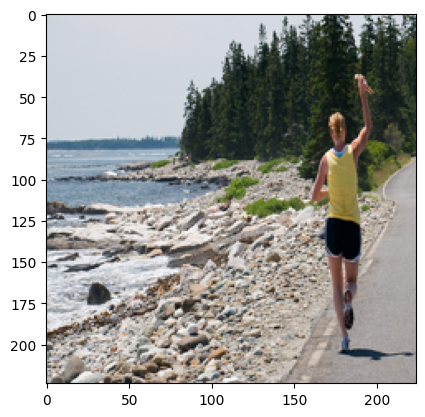

Caption: man in black shorts and jeans is walking on beach with the mountains in the background
Real: woman in yellow jogging
Real: woman is jogging on road by shoreline holding an item up in the air
Real: woman jogs down the rode near rocky shore
Real: woman passing by the shore
Real: the woman in the yellow shirt jogged along the coastline



In [120]:
import matplotlib.pyplot as plt

for i in chaves_teste[:5]:
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    img_path = os.path.join(IMAGES_PATH, i)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.show()
    print(f"Caption: {caption[9:-7]}")
    for cap in dict_img_to_captions[i]:
        print(f"Real: {cap[9:-7]}")
    print()

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(candidate: str, references: list):
    """
    Calcula o BLEU score para uma frase candidata comparada a uma ou mais referências.

    Args:
        candidate (str): Texto gerado automaticamente.
        references (list): Lista de textos de referência.

    Returns:
        float: BLEU score.
    """
    # Suavização para lidar com n-gramas ausentes
    smoothing_function = SmoothingFunction().method1

    # Calcula o BLEU score
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothing_function, weights=(1, 0, 0, 0))
    return bleu_score

In [ ]:
scores = []
for i in tqdm(chaves_teste):
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    references = [cap for cap in dict_img_to_captions[i]]
    bleu = calculate_bleu(caption, references)
    scores.append(bleu)

print(f"BLEU médio: {np.mean(scores)}")

 44%|████▍     | 713/1619 [05:37<07:09,  2.11it/s]


KeyboardInterrupt: 